
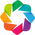

In [25]:
%matplotlib inline
import copy
import numpy as np
import os
import pandas as pd
import holoviews as hv
from daq.pico import CSV
from easier import ParamState, shade, Item
from harmonic_analyzer import HarmonicAnalyzer
from harmonic import Harmonic
from pandashells.lib.lomb_scargle_lib import lomb_scargle
from scipy.fftpack import fft, fftshift, ifftshift
hv.extension('bokeh')
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from scipy.optimize import fmin_powell
from scipy import signal
import seaborn as sns
# import matplotlib as mpl
from pylab import rcParams
# import dask
from dask import compute, delayed
import dask.multiprocessing
sns.set_context('talk')
sns.set(style='darkgrid')
from easier import Timer


import pylab as pl
pl.rcParams['figure.figsize'] = 11, 8.5


In [8]:
%opts Curve [width=700, height=400 show_grid=True tools=['hover']]
%opts Scatter (size=5,)
%opts RGB [width=700, height=400]


In [9]:
test_log_file = '20180118_test_log.csv'
data_dir = './20180118//'
drive_freq = 25
channel_mapper= dict(
    a='sig_gen',
    b='res_volt',
    c='rec_volt',
    d='sec_volt'
)
df_log = pd.read_csv(test_log_file).drop(['test_no', 'excitor_position'], axis=1)
df_log = df_log.rename(columns=dict(exciter_rel_to_crack='pos'))
df_log = df_log.set_index(['sample', 'pos']).sort_index()[['filename']]

df_log

filename
sample pos                   
broken -39  20180118-0016.csv
       -35  20180118-0017.csv
       -31  20180118-0018.csv
       -27  20180118-0019.csv
       -23  20180118-0020.csv
       -19  20180118-0021.csv
       -15  20180118-0022.csv
       -11  20180118-0023.csv
       -7   20180118-0024.csv
       -3   20180118-0025.csv
        1   20180118-0026.csv
        5   20180118-0027.csv
        9   20180118-0028.csv
        13  20180118-0029.csv
        17  20180118-0030.csv
virgin -39  20180118-0001.csv
       -35  20180118-0002.csv
       -31  20180118-0003.csv
       -27  20180118-0004.csv
       -23  20180118-0005.csv
       -19  20180118-0006.csv
       -15  20180118-0007.csv
       -11  20180118-0008.csv
       -7   20180118-0009.csv
       -3   20180118-0010.csv
        1   20180118-0011.csv
        5   20180118-0012.csv
        9   20180118-0013.csv
        13  20180118-0014.csv
        17  20180118-0015.csv

In [86]:
"""
Care about
amp/phase of primary current to secondary voltage
frac of power in the 3rd harmonic of secondary
"""

def processor(sample, pos, file_name_ser):
    file_name = os.path.join(data_dir, file_name_ser[0])
    print(file_name)
    df = CSV(file_name=file_name, max_sample_freq=1e9,  **channel_mapper).df
    harmonics = [1, 3]

    # fit the primary current
    h_i_prim = Harmonic(harmonics=harmonics)
    h_i_prim.fit(df.t, df.res_volt)
    
    # fit the secondary voltage
    h_v_sec = Harmonic(harmonics=harmonics)
    h_v_rec = Harmonic(harmonics=harmonics)
    h_v_sec.fit(df.t, df.sec_volt)
    h_v_rec.fit(df.t, df.rec_volt)
    
    # compute an impedence object
    h_z_prim_sec = h_v_sec / h_i_prim
    h_z_prim_rec = h_v_rec / h_i_prim
    h_z_sec_rec = h_v_rec / h_v_sec 
    
    
    # populate some results
    rec = dict(
        sample=sample,
        pos=pos,
        prim_rec_amp=h_z_prim_rec.amplitudes[0],
        prim_sec_amp=h_z_prim_sec.amplitudes[0],
        sec_rec_amp=h_z_sec_rec.amplitudes[0],
        prim_rec_phi=h_z_prim_rec.phases[0],
        prim_sec_phi=h_z_prim_sec.phases[0],
        sec_rec_phi=h_z_sec_rec.phases[0],
        h_db_sec = 10*np.log10(h_v_sec.amplitudes[1] ** 2 / np.sum(h_v_sec.amplitudes ** 2)),
        h_db_rec = 10*np.log10(h_v_rec.amplitudes[1] ** 2 / np.sum(h_v_rec.amplitudes ** 2)),
    )
    return rec
    
future_list = []

def mydelayed(func):
    return func

def mycompute(*inlist, **kwargs):
    return inlist

delay_func = delayed
compute_func = compute

with Timer('processing'):
    for (sample, pos), file_name_ser in list(df_log.iterrows()):
        future = delay_func(processor)(sample, pos, file_name_ser)
        future_list.append(future)
    rec_list = list(compute_func(*future_list, get=dask.multiprocessing.get))
    dfr = pd.DataFrame(rec_list, columns=list(rec_list[0].keys()))
    dfr.to_csv('dfr.csv', index=False)

./20180118//20180118-0028.csv
./20180118//20180118-0003.csv
./20180118//20180118-0017.csv
./20180118//20180118-0026.csv
./20180118//20180118-0022.csv
./20180118//20180118-0010.csv
./20180118//20180118-0023.csv
./20180118//20180118-0008.csv
./20180118//20180118-0007.csv
./20180118//20180118-0019.csv
./20180118//20180118-0009.csv
./20180118//20180118-0024.csv
./20180118//20180118-0013.csv
./20180118//20180118-0006.csv
./20180118//20180118-0021.csv
./20180118//20180118-0025.csv
./20180118//20180118-0005.csv
./20180118//20180118-0001.csv
./20180118//20180118-0014.csv
./20180118//20180118-0020.csv
./20180118//20180118-0027.csv
./20180118//20180118-0012.csv
./20180118//20180118-0004.csv
./20180118//20180118-0029.csv
./20180118//20180118-0016.csv
./20180118//20180118-0018.csv
./20180118//20180118-0011.csv
./20180118//20180118-0030.csv
./20180118//20180118-0002.csv
./20180118//20180118-0015.csv
__time__,112.011494,processing


In [87]:
dfr = pd.read_csv('dfr.csv').sort_values(by=['sample', 'pos'])
dfr.head()

,sample,pos,prim_rec_amp,prim_sec_amp,sec_rec_amp,prim_rec_phi,prim_sec_phi,sec_rec_phi,h_db_sec,h_db_rec
0,broken,-39,14.622019,10.051393,1.454726,-0.715641,-1.368847,0.653206,-41.381120,-27.656500
1,broken,-35,20.731454,14.126361,1.467572,-0.588626,-1.233961,0.645335,-40.641068,-27.589750
2,broken,-31,21.864260,14.791238,1.478190,-0.537016,-1.184731,0.647714,-40.307470,-27.834078
3,broken,-27,21.852928,14.878886,1.468721,-0.514831,-1.167133,0.652302,-40.542364,-27.837927
4,broken,-23,21.814354,14.911596,1.462912,-0.504493,-1.162271,0.657779,-40.656154,-27.661548


In [88]:
dfx = dfr.set_index(['pos', 'sample']).unstack('sample').sort_index(axis=1)
# dfx.columns = dfx.columns.swaplevel()
dfx.sort_index(axis=1).reset_index().head()

pos   h_db_rec              h_db_sec            prim_rec_amp  \
sample         broken     virgin     broken     virgin       broken   
0      -39 -27.656500 -26.366105 -41.381120 -41.249427    14.622019   
1      -35 -27.589750 -27.059345 -40.641068 -40.196454    20.731454   
2      -31 -27.834078 -27.363808 -40.307470 -40.355817    21.864260   
3      -27 -27.837927 -27.386673 -40.542364 -40.329838    21.852928   
4      -23 -27.661548 -27.526986 -40.656154 -40.417398    21.814354   

                  prim_rec_phi           prim_sec_amp            prim_sec_phi  \
sample     virgin       broken    virgin       broken     virgin       broken   
0       14.472237    -0.715641 -0.735573    10.051393  10.025023    -1.368847   
1       20.232075    -0.588626 -0.611196    14.126361  14.063553    -1.233961   
2       21.463994    -0.537016 -0.552826    14.791238  14.803930    -1.184731   
3       21.587709    -0.514831 -0.526315    14.878886  14.912490    -1.167133   
4       21.561078    -0.504493 -0.520239    14.911596  14.873160    -1.162271   

                 sec_rec_amp           sec_rec_phi            
sample    virgin      broken    virgin      broken    virgin  
0      -1.375350    1.454726  1.443611    0.653206  0.639777  
1      -1.245438    1.467572  1.438618    0.645335  0.634242  
2      -1.193896    1.478190  1.449885    0.647714  0.641069  
3      -1.176524    1.468721  1.447626    0.652302  0.650210  
4      -1.170036    1.462912  1.449664    0.657779  0.649797

In [89]:
diff_dict = {}
for var in dfx.columns.levels[0]:
    dfd = dfx.loc[:, pd.IndexSlice[var]]
    diff_dict[var] = (dfd['broken'] - dfd['virgin'])
    
dfp = pd.melt(pd.DataFrame(diff_dict).reset_index(), id_vars='pos')
dfp.head()

,pos,variable,value
0,-39,h_db_rec,-1.290395
1,-35,h_db_rec,-0.530405
2,-31,h_db_rec,-0.470270
3,-27,h_db_rec,-0.451254
4,-23,h_db_rec,-0.134562


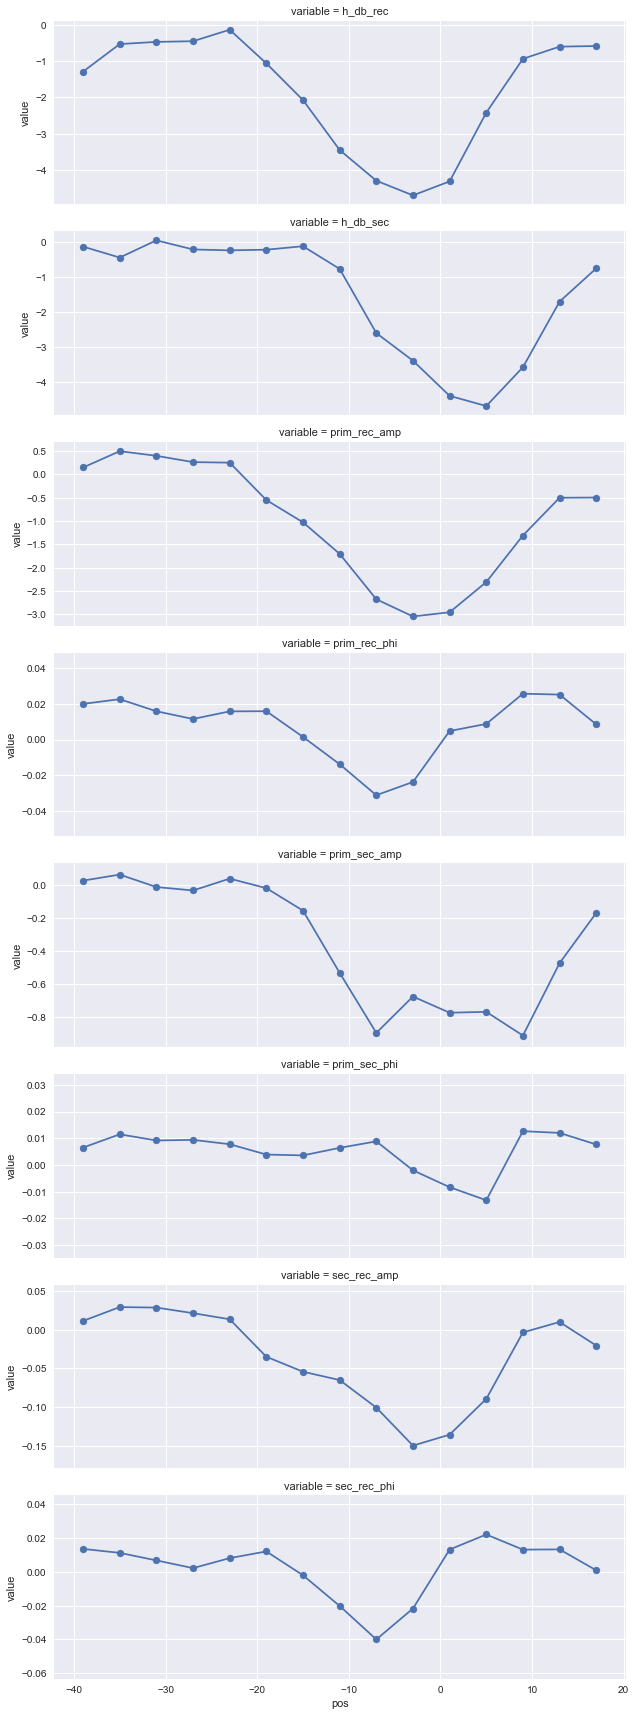

In [90]:
g = sns.FacetGrid(dfp, row='variable', sharey=False, size=3, aspect=3)
g.map(plotter, 'pos', 'value')
pl.savefig('rob.png')

In [78]:
pl.savefig(fig, 'rob.pdf')

TypeError: print_figure() got multiple values for argument 'dpi'

In [57]:
dfx.columns.swaplevel()

MultiIndex(levels=[['broken', 'virgin'], ['hfrac_rec', 'hfrac_sec', 'prim_rec_amp', 'prim_rec_phi', 'prim_sec_amp', 'prim_sec_phi', 'sec_rec_amp', 'sec_rec_phi']],
           labels=[[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]],
           names=['sample', None])

In [50]:
dfx = pd.melt(dfr, id_vars=['sample', 'pos'])
dfx.head()

,sample,pos,variable,value
0,broken,-39,z_prim_rec_amp,14.622019
1,broken,-35,z_prim_rec_amp,20.731454
2,broken,-31,z_prim_rec_amp,21.864260
3,broken,-27,z_prim_rec_amp,21.852928
4,broken,-23,z_prim_rec_amp,21.814354


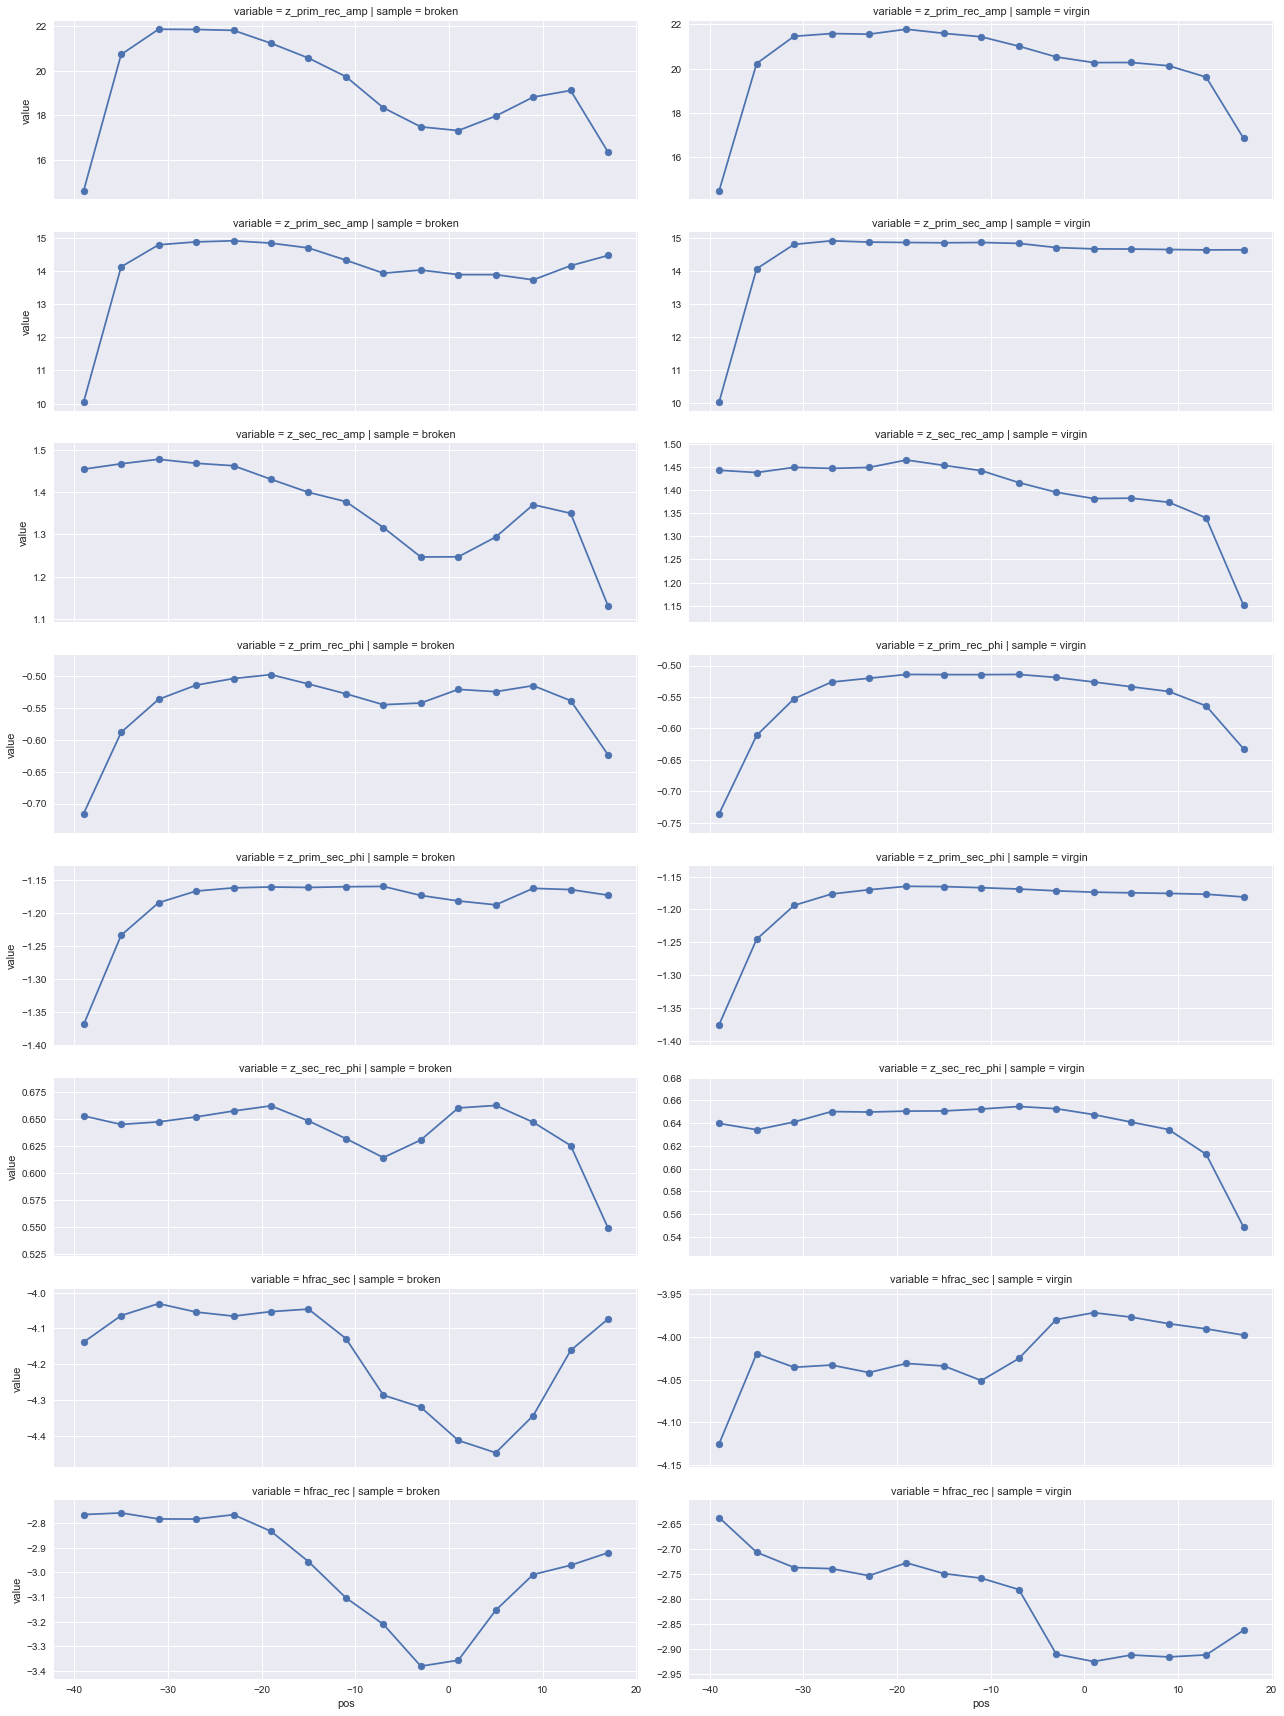

In [51]:
g = sns.FacetGrid(dfx, col='sample', row='variable', sharey=False, size=3, aspect=3)
g.map(plotter, 'pos', 'value')

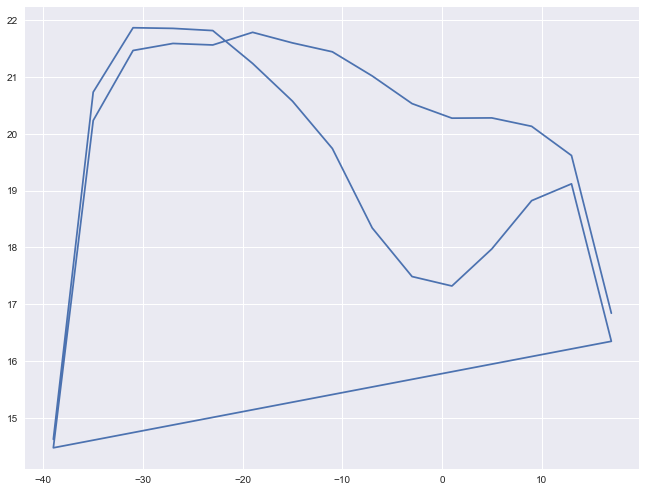

In [38]:
pl.plot(dfr.pos, dfr.z_prim_rec_amp)

In [ ]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)


In [43]:
def plotter(*args, **kwargs):
    pl.scatter(*args, **kwargs)
    pl.plot(*args, **kwargs)

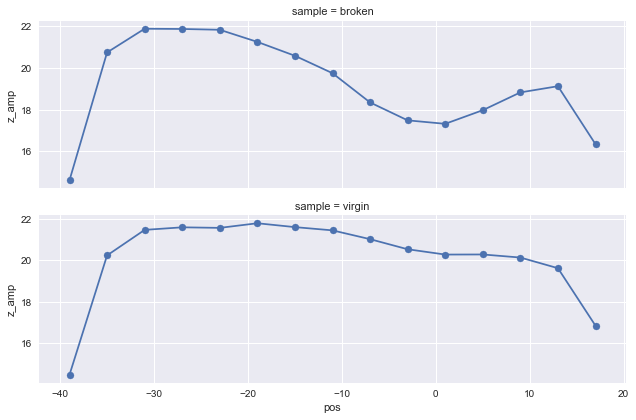

In [14]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)

g.map(plotter , 'pos', 'z_amp')
pl.savefig('z_amp.pdf')

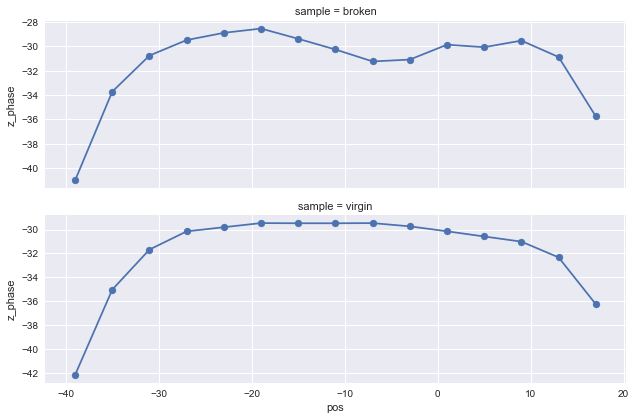

In [15]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)

g.map(plotter , 'pos', 'z_phase')
pl.savefig('z_phase.pdf')

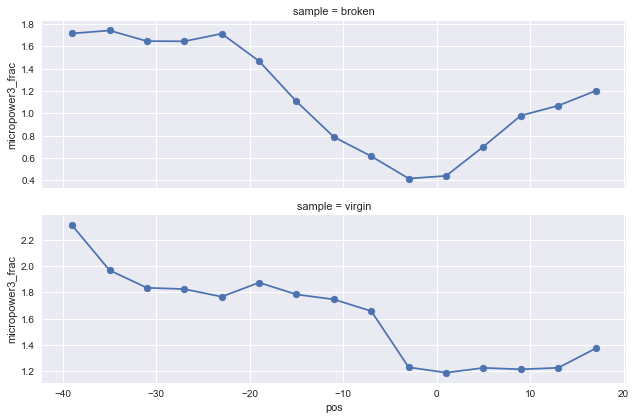

In [16]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)

    
g.map(plotter , 'pos', 'micropower3_frac')
pl.savefig('harmonic_power.pdf')

In [17]:
dfr.head()

,sample,pos,z_amp,z_phase,micropower3_frac
0,broken,-39,14.622019,-41.003232,1.715339
1,broken,-35,20.731454,-33.725765,1.741907
2,broken,-31,21.864260,-30.768776,1.646615
3,broken,-27,21.852928,-29.497669,1.645157
4,broken,-23,21.814354,-28.905302,1.713347


In [18]:
dfx = dfr.set_index(['sample', 'pos']).unstack('sample').sort_index(axis=1)
dfx

micropower3_frac                z_amp               z_phase           
sample           broken    virgin     broken     virgin     broken     virgin
pos                                                                          
-39            1.715339  2.308817  14.622019  14.472237 -41.003232 -42.145210
-35            1.741907  1.968183  20.731454  20.232075 -33.725765 -35.018959
-31            1.646615  1.834929  21.864260  21.463994 -30.768776 -31.674611
-27            1.645157  1.825293  21.852928  21.587709 -29.497669 -30.155623
-23            1.713347  1.767264  21.814354  21.561078 -28.905302 -29.807505
-19            1.467574  1.874548  21.235480  21.783648 -28.556198 -29.463375
-15            1.106294  1.784292  20.572099  21.597278 -29.394193 -29.477000
-11            0.788635  1.746952  19.739030  21.440830 -30.271541 -29.478597
-7             0.615839  1.658082  18.341488  21.016007 -31.250494 -29.463879
-3             0.416607  1.231472  17.485864  20.529008 -31.098344 -29.736006
 1             0.440304  1.190704  17.319634  20.273166 -29.876748 -30.149150
 5             0.702361  1.227000  17.971373  20.277603 -30.082495 -30.582278
 9             0.980119  1.216124  18.821473  20.129634 -29.542242 -31.011935
 13            1.068784  1.227493  19.117433  19.615947 -30.886567 -32.326715
 17            1.201723  1.374827  16.346379  16.840656 -35.752225 -36.237742

In [19]:
field = 'micropower3_frac'
field = 'z_amp'
dfy = dfx.loc[:, pd.IndexSlice[field]].reset_index()
dfy.columns.name = None
dfy.loc[:, 'delta'] = list(dfy.broken - dfy.virgin)
dfy.head()

,pos,broken,virgin,delta
0,-39,14.622019,14.472237,0.149783
1,-35,20.731454,20.232075,0.499379
2,-31,21.864260,21.463994,0.400266
3,-27,21.852928,21.587709,0.265219
4,-23,21.814354,21.561078,0.253276


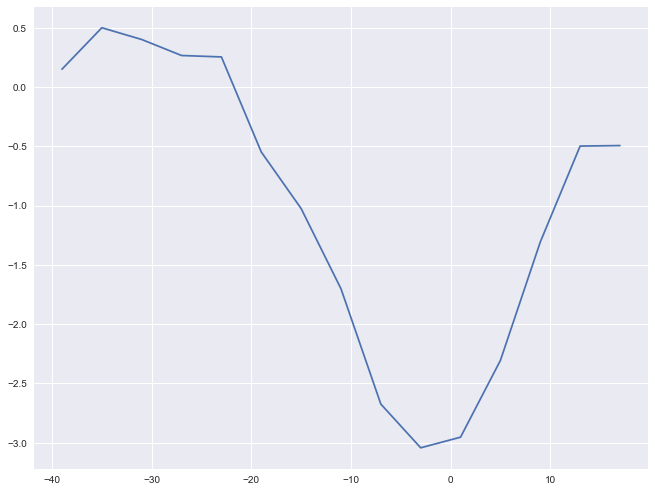

In [20]:
pl.plot(dfy.pos, dfy.delta)

In [ ]:
# # Code for plotting fits
# x = df.t
# y = df.sec_volt
# h = Harmonic(harmonics=[1, 3])
# h.fit(x, y, alpha=.0001, method='regression')
# y_fit = h.predict(x)
# resid = y - y_fit
# b, a = signal.butter(2, 0.001)
# resid_smooth = signal.filtfilt(b, a, resid, padlen=150)
# (
#     shade(hv.Curve((x, y)))
#     * shade(hv.Curve((x, y_fit), kdims=['time'], vdims=['amp']), color='red')
#     + (
#         shade(hv.Curve((x, resid), vdims=['resid']), color='blue')
#         *shade(hv.Curve((x, resid_smooth)), color='red')
#     )
        
    
# ).cols(1)